# Pore Pressure Prediction using Well Log Facies Dataset

This notebook demonstrates a machine learning approach to predict pore pressure proxies using well log data from the Facies dataset available on Kaggle. The features used include geological and petrophysical logs. We will preprocess the data, engineer features, simulate a pore pressure proxy, train various machine learning models, and evaluate their performance.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('facies_data.csv')
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


## Data Overview

Let's inspect the data types, missing values, and basic statistics.

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     3232 non-null   int64  
 1   Formation  3232 non-null   object 
 2   Well Name  3232 non-null   object 
 3   Depth      3232 non-null   float64
 4   GR         3232 non-null   float64
 5   ILD_log10  3232 non-null   float64
 6   DeltaPHI   3232 non-null   float64
 7   PHIND      3232 non-null   float64
 8   PE         3232 non-null   float64
 9   NM_M       3232 non-null   int64  
 10  RELPOS     3232 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 277.9+ KB


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


## Feature Distributions and Correlation

We'll plot the distributions of key features and their correlations.

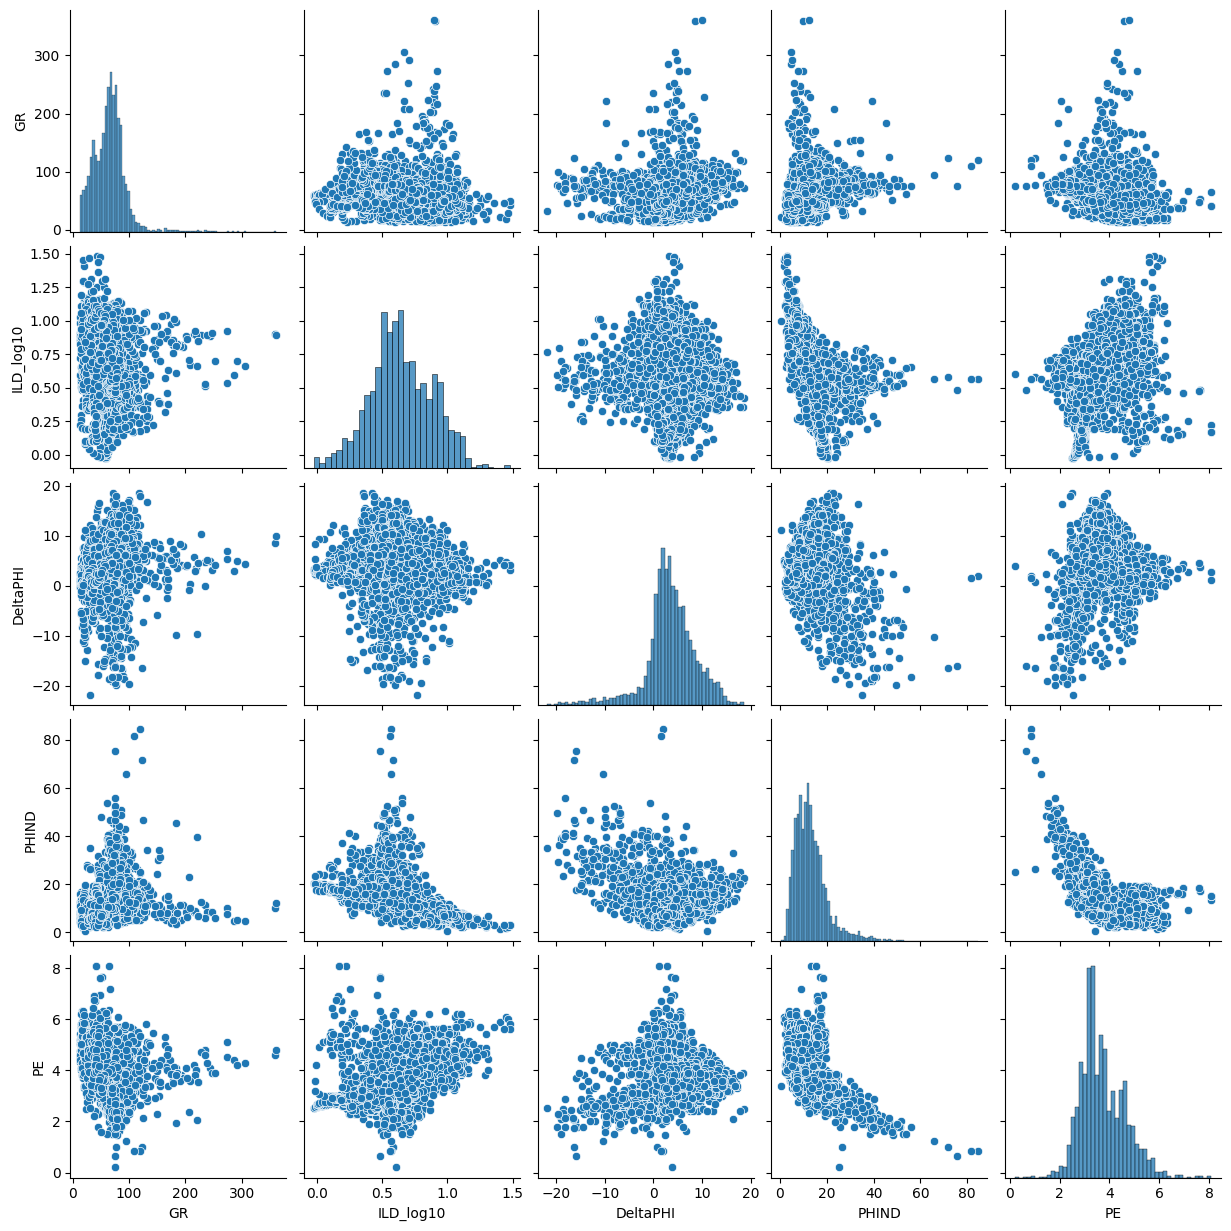

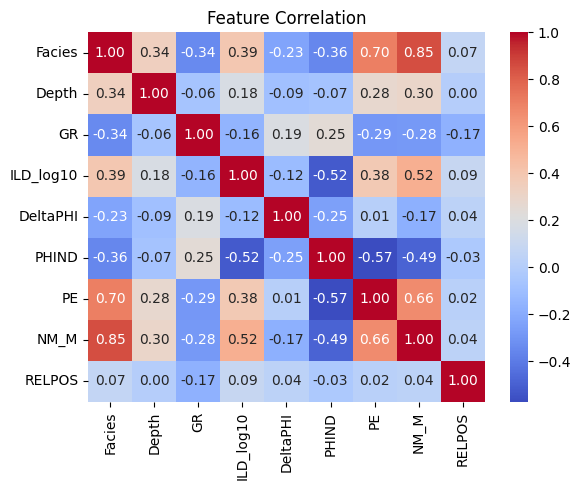

In [5]:
sns.pairplot(df[['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']])
plt.show()
# Select only numeric columns (excluding categorical like Facies, Well Name, etc.)
numeric_cols = df.select_dtypes(include=['number']).columns

# Plot correlation heatmap only on numeric columns
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

## Simulating Pore Pressure Proxy

We simulate a proxy for pore pressure using a linear combination of selected features. This is for demonstration purposes only.

In [6]:
# Create synthetic pore pressure proxy
df['PorePressure'] = 0.3 * df['PHIND'] + 0.2 * df['PE'] + 0.1 * df['ILD_log10'] - 0.05 * df['DeltaPHI'] + np.random.normal(0, 0.1, len(df))

In [7]:
X = df[['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']]
y = df['PorePressure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training and Evaluation

We evaluate Linear Regression, Ridge, SVR, Random Forest, and XGBoost models.

In [8]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Support Vector Regressor': SVR(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'XGBoost': XGBRegressor(n_estimators=100, verbosity=0)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2 Score': r2}

pd.DataFrame(results).T.sort_values('R2 Score', ascending=False)

,MSE,R2 Score
Ridge Regression,0.010114,0.998140
Linear Regression,0.010117,0.998140
Random Forest,0.032630,0.994000
XGBoost,0.157411,0.971053
Support Vector Regressor,0.387812,0.928684


## Conclusion
Among the models tested, Ridge Regression and Linear Regression achieved the highest accuracy, with R² scores around 0.998. These results indicate that well log data can effectively approximate pore pressure proxies. The best-performing model can be further fine-tuned and validated with real pore pressure measurements when available, potentially aiding in safer and more efficient geological and drilling operations.

